<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="900px"/> 

### <a id="title_ID"></a>
# MIRI MRS Calibration Notebook  #3 (Extended Sources) #

**Author**: David Law, AURA Associate Astronomer, MIRI branch
<br>
**Last Updated**: February 28, 2022

## Table of contents
1. [Introduction](#intro)<br>
   1.1 [Purpose of this Notebook](#purpose)<br>
   1.2 [Input Simulations](#inputs)<br>
   1.3 [Caveats for Simulated Data](#mirisim)<br>
2. [Setup](#setup)<br>
   2.1 [CRDS Context](#crds)<br>
   2.2 [Python Imports](#imports)<br>
   2.3 [Data I/O Directories](#iodir)<br>
   2.4 [Reprocessing Flag](#redo)<br>
3. [Detector1 Pipeline](#det1)<br>
4. [Spec2 Pipeline](#spec2)<br>
5. [Spec3 Pipeline: Default configuration (Per-band cubes)](#spec3)<br>
8. [Examine the output cubes, and compare spectra to the simulation inputs](#examine)<br>

<hr style="border:1px solid gray"> </hr>

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

### 1.1<font color='white'>-</font>Purpose of this Notebook<a class="anchor" id="purpose"></a> ###

In this notebook we provide a series of realistic examples for running the JWST pipeline on EXTENDED-source MIRI MRS observations similar to those that will be obtained by many Cycle 1 observing programs.  In particular, we focus on difference between the extended-source and point-source pipelines.  We therefore do not discuss the purpose and input/output of each individual pipeline step, but focus on ways to modify the final pipeline output for the best scientific utility.  For a walkthrough of individual steps, see Notebook #1.  Similarly, this will cover the baseline pipeline as it exists in February 2022 and does not touch advanced algorithms or steps still under development.  Likewise, this notebook omits the parallel processing that was explored in Notebook #2, and is less relevant now that cube building uses C bindings instead of pure python (and hence runs 30x faster).

We will start with a simple simulated MRS extended source observation (created using mirisim: https://wiki.miricle.org/Public/MIRISim_Public) with a dedicated background, process the data through the Detector1 pipeline (which turns raw detector counts into uncalibrated rate images), the Spec2 pipeline (which turns uncalibrated rate images into calibrated rate images), and the Spec3 pipeline (which turns calibrated rate images into composite data cubes and extracted 1d spectra).

A few additional caveats:
- This notebook covers the v1.4.3 baseline pipeline as it existed in February 2022.  The pipeline is under continuous development and will evolve further throughout commissioning.
- Likewise, there are some advanced algorithms slated for development prior to cycle 1 observations that will not be discussed here.

### 1.2<font color='white'>-</font>Input Simulations<a class="anchor" id="inputs"></a> ###

As input to this notebook, we'll be using a 4-pt dithered observation of an extended source created using mirisim that covers the 'A' grating setting (i.e., both MIRI detectors, with the SHORT grating configuration).  The source spectrum is chosen to be astrophysically realistic, in this case taken from the galaxy NGC 5728.

<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/scene3.png' alt="nb3input" width="900px"/> 

### 1.3<font color='white'>-</font>Caveats for Simulated Data<a class="anchor" id="mirisim"></a> ###

As noted above, in this notebook we will be processing simulated data created with the 'mirisim' tool.  Like the pipeline, mirisim is also an evolving piece of software and there are multiple known issues that can cause problems.  A few of the most important such mirisim issues include:

- FAST mode has incorrect noise properties, rendering FAST mode data processed by the pipeline unreliable.  The simulations in this notebook therefore use simulated SLOW mode data.

- Extended sources are not simulated unless they meet a minimum size that varies with each band.

- Point sources are not simulated properly, with the PSF profile being simulated incorrectly in the cores.  Mirisim simulations therefore should not be used to study the PSF shape.

- Reference pixels are not treated consistently, the refpix step of detector1 must therefore be turned off to process mirisim data without artifacts.

- Channel 4 flux calibration is incorrect in mirisim.  No workaround is currently available- channel 4 fluxes provided by the pipeline from simulated data will be incorrect.

- WCS alignment is incorrect in mirisim, causing sources to jump in location by a couple of pixels between channels.  No workaround is available- do not use mirisim data to test spatial alignment.

- Flux conservation is not perfect within mirisim.  Likewise, the aperture correction factors in use by the pipeline correspond to the expected performance in flight (to be udpated during on-orbit commissioning) and are not well matched to mirisim data.  No workaround available, do not use mirisim data to test flux conservation.

- mirisim does not add all of the necessary header keywords for the pipeline to know how to do background subtraction, identify source type, etc.  In order to get these APT-derived keywords correct they will need to be set manually.

<hr style="border:1px solid gray"> </hr>

2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

In this section we set things up a number of necessary things in order for the pipeline to run successfully.

First we'll set the CRDS context; this dictates the versions of various pipeline reference files to use.  Ordinarily you wouldn't want to set a specific version as the latest pipeline should already use the most-recent reference files (and hard-coding a version could get you old reference files that have since been replaced).  However, it's included here as a reference for how to do so.

Next we'll import the various python packages that we're actually going to use in this notebook, including both generic utility functions and the actual pipeline modules themselves.

Next, we'll specify the data directory structure that we want to use.  In order to keep our filesystem clean we'll separate simulated inputs and outputs from each pipeline stage into their own folders.

Finally, for convenience in this JWebbinar we'll define a flag that sets whether or not to actually run some of the longer pipeline steps in this notebook or just to rely upon cached reductions provided ahead of time.  This is because a number of steps can take quite a long time to run, and in a short Webbinar we don't want to be waiting for them to all run in real time.  This flag is set to False by default for use in the live Webbinar; if you want to experiment with running all steps yourself ahead of time just set this flag to True.  Total notebook runtime with True/False values is about 25 minutes vs 1 second.

### 2.1<font color='white'>-</font>CRDS Context<a class="anchor" id="crds"></a> ###

In [1]:
# Set our CRDS context for reference files if desired (see https://jwst-crds.stsci.edu/)
#%env CRDS_CONTEXT jwst_0723.pmap

### 2.2<font color='white'>-</font>Python Imports <a class="anchor" id="imports"></a> ###

In [2]:
# Now let's use the entire available screen width for the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/var/folders/lg/jw_brb093bl9n39fbgn1cw080001fw/T/ipykernel_66765/1813087124.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# Basic system utilities for interacting with files
import glob
import sys
import os
import time
import shutil
import warnings
import zipfile
import urllib.request

# Astropy utilities for opening FITS and ASCII files
from astropy.io import fits
from astropy.io import ascii
from astropy.utils.data import download_file
# Astropy utilities for making plots
from astropy.visualization import (LinearStretch, LogStretch, ImageNormalize, ZScaleInterval)

# Numpy for doing calculations
import numpy as np

# Matplotlib for making plots
import matplotlib.pyplot as plt
from matplotlib import rc

# JWST pipelines (encompassing many steps)
import jwst
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

# JWST pipeline utilities
from stcal import dqflags # Utilities for working with the data quality (DQ) arrays
from jwst import datamodels # JWST datamodels
import stcal.ramp_fitting.utils as utils # Utilities for handling multiprocessing
from jwst.associations import asn_from_list as afl # Tools for creating association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base # Definition of a Lvl3 association file

In [4]:
# Print out what pipeline version we're using
print('JWST pipeline version',jwst.__version__)

JWST pipeline version 1.3.3.dev153+g5ce9e04b8


### 2.3<font color='white'>-</font>Data I/O Directories <a class="anchor" id="iodir"></a> ###

Data for this notebook comes in two parts, a stage0/ directory that contains the mirisim inputs to the pipeline, and a cache/ directory containing pre-reduced stage1, stage2, and stage3 pipeline results. This cache directory is intended to provide reference examples against which new reductions can be compared, or to serve as the source of intermediate-stage pipeline inputs if skipping lengthy processing steps in this notebook.

These directories are zipped together and can be downloaded from Box automatically using the code below. However, since the zip file is quite large (~ 1 GB) it can also take a few minutes or more to download, and can be downloaded through any other means and extracted into the target data directory.

In [5]:
# input_dir should point to where you installed the data from Box
input_dir = './'

ziplink = 'https://stsci.box.com/shared/static/z1wm5mmlzhfrnxx9ihlw6fiw3rgty37h.zip'
zipfilename = 'mrs_data3.zip'

# Look for a stage0/ directory, if not found then download the data
if os.path.isdir(os.path.join(input_dir, 'stage0/')):
    print('stage0/ input directory already exists, skipping download.')
else:
    print('Downloading {}...'.format(zipfilename))
    demo_file = download_file(ziplink, cache=True)
    # Make a symbolic link using a local name for convenience
    os.symlink(demo_file, os.path.join(input_dir, zipfilename))
    zf = zipfile.ZipFile(os.path.join(input_dir, zipfilename), 'r')
    print('Extracting zip file...')
    zf.extractall(input_dir)
    print('Cleaning up.')
    os.remove(os.path.join(input_dir, zipfilename))

stage0/ input directory already exists, skipping download.


In [6]:
# Set up mirisim input path
mirisim_dir = os.path.join(input_dir, 'stage0/') # Simulated inputs are here

# Set up cache paths
det1_cachedir = os.path.join(input_dir, 'cache/stage1/') # Cached Detector1 pipeline outputs are here
spec2_cachedir = os.path.join(input_dir, 'cache/stage2/') # Cached Spec2 pipeline outputs are here
spec3_cachedir = os.path.join(input_dir, 'cache/stage3/') # Cached Spec3 pipeline outputs are here

In [7]:
# output_dir should point to where you want the output results to go
output_dir = './'

# Specify output directories to keep data products organized
det1_dir = os.path.join(output_dir, 'stage1/') # Detector1 pipeline outputs will go here
spec2_dir = os.path.join(output_dir, 'stage2/') # Spec2 pipeline outputs will go here
spec3_dir = os.path.join(output_dir, 'stage3/') # Spec3 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(spec2_dir):
    os.makedirs(spec2_dir)
if not os.path.exists(spec3_dir):
    os.makedirs(spec3_dir)

### 2.4<font color='white'>-</font>Reprocessing Flag<a class="anchor" id="redo"></a> ###

In [8]:
# Finally, we'll set a processing directive about whether to rerun long steps in this notebook or not
redolong = True

# With this flag set to False, you'll use pre-reduced outputs.  
# If you want to experiment with setting it to True ahead of time
# you can recreate all of your own outputs.

<hr style="border:1px solid gray"> </hr>

3.<font color='white'>-</font>Detector1 Pipeline <a class="anchor" id="det1"></a>
------------------

<div class="alert alert-block alert-warning">
In this section we process our simulated data through the Detector1 pipeline to create Lvl2a data products (i.e., uncalibrated slope images).  We will turn off the reference pixel subtraction step as it does not handle mirisim data well.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html
</div>

In [9]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

In [10]:
# First we'll define a function that will call the detector1 pipeline with our desired set of parameters
# We won't enumerate the individual steps
def rundet1(filenames):
    det1=Detector1Pipeline() # Instantiate the pipeline
    det1.output_dir = det1_dir # Specify where the output should go
    det1.refpix.skip = True # Skip the reference pixel subtraction (as it doesn't interact well with simulated data)
    det1.save_results = True # Save the final resulting _rate.fits files
    det1(filenames) # Run the pipeline on an input list of files

In [11]:
# Now let's look for input files in our (cached) mirisim simulation directory
sstring=mirisim_dir+'det*exp1.fits'
simfiles=sorted(glob.glob(sstring))
print('Found ' + str(len(simfiles)) + ' input files to process')

Found 10 input files to process


In [12]:
# Run the pipeline on these input files by a simple loop over our pipeline function

# If rerunning long pipeline steps, actually run the step
if (redolong == True):
    for file in simfiles:
        rundet1(file)
    
# Otherwise, just copy cached outputs into our output directory structure
else:
    sstring = os.path.join(det1_cachedir, 'det*rate.fits')
    files = sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file, det1_cachedir, det1_dir)
        shutil.copy(file, outfile)

2022-02-28 15:26:28,164 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-02-28 15:26:28,167 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-02-28 15:26:28,169 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-02-28 15:26:28,170 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-02-28 15:26:28,172 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-02-28 15:26:28,174 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-02-28 15:26:28,176 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-02-28 15:26:28,178 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-02-28 15:26:28,179 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-02-28 15:26:28,182 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-02-28 1

2022-02-28 15:26:30,144 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2022-02-28 15:26:30,145 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_readnoise_0064.fits'.
2022-02-28 15:26:30,146 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2022-02-28 15:26:30,146 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_rscd_0011.fits'.
2022-02-28 15:26:30,147 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_saturation_0024.fits'.
2022-02-28 15:26:30,148 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2022-02-28 15:26:30,149 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2022-02-28 15:26:30,149 - stpipe.Detector1Pipel

2022-02-28 15:26:33,359 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2022-02-28 15:26:33,463 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 20, 1024, 1032) from det_bg_seq1_MIRIFULONG_34SHORTexp1.fits>,).
2022-02-28 15:26:33,465 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'dark_output': None}
2022-02-28 15:26:33,499 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0057.fits
2022-02-28 15:26:34,126 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=20, nframes=1, groupgap=0
2022-02-28 15:26:34,127 - stpipe.Detect

2022-02-28 15:27:00,037 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-02-28 15:27:00,039 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-02-28 15:27:00,040 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-02-28 15:27:00,042 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-02-28 15:27:00,044 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-02-28 15:27:00,045 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-02-28 15:27:00,047 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-02-28 15:27:00,049 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2022-02-28 15:27:00,050 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2022-02-28 15:27:00,052 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2022-02

2022-02-28 15:27:00,343 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_rscd_0012.fits'.
2022-02-28 15:27:00,343 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_saturation_0025.fits'.
2022-02-28 15:27:00,344 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2022-02-28 15:27:00,345 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2022-02-28 15:27:00,346 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2022-02-28 15:27:00,346 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2022-02-28 15:27:00,567 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 20, 1024, 1032) from det_bg_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).
2022-02-28 15:27:00,568 - stpipe.Detector1Pipeli

2022-02-28 15:27:03,712 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0044.fits
2022-02-28 15:27:04,339 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=20, nframes=1, groupgap=0
2022-02-28 15:27:04,340 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0
2022-02-28 15:27:04,613 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2022-02-28 15:27:04,752 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 20, 1024, 1032) from det_bg_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).
2022-02-28 15:27:04,754 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 's

2022-02-28 15:27:31,377 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-02-28 15:27:31,379 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2022-02-28 15:27:31,380 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2022-02-28 15:27:31,382 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2022-02-28 15:27:31,383 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2022-02-28 15:27:31,385 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2022-02-28 15:27:31,387 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2022-02-28 15:27:31,389 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2022-02-28 15:27:31,521 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./stage0/det_image_seq1_MIRIFULONG_34SHORTexp1.fits',).
2022-02-28 15:27:31,536 - stpipe.Det

2022-02-28 15:27:31,662 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2022-02-28 15:27:31,663 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2022-02-28 15:27:31,904 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 20, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).
2022-02-28 15:27:31,906 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0'}
2022-02-28 15:27:32,002 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed
2022-02-28 15:27:32,003 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped
2022-02-28 15:27:32,006 - stpipe.

2022-02-28 15:27:35,553 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0
2022-02-28 15:27:35,843 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2022-02-28 15:27:35,997 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 20, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).
2022-02-28 15:27:35,999 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2022-02-28 15:27:36,000 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2022-02-28 15:27:36,003 - stpipe.Detec

2022-02-28 15:28:02,530 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2022-02-28 15:28:02,531 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2022-02-28 15:28:02,533 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2022-02-28 15:28:02,535 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2022-02-28 15:28:02,536 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2022-02-28 15:28:02,669 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./stage0/det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits',).
2022-02-28 15:28:02,683 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input

2022-02-28 15:28:03,059 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0'}
2022-02-28 15:28:03,148 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed
2022-02-28 15:28:03,149 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped
2022-02-28 15:28:03,152 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done
2022-02-28 15:28:03,240 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 20, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).
2022-02-28 15:28:03,243 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_fil

2022-02-28 15:28:07,170 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2022-02-28 15:28:07,171 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2022-02-28 15:28:07,174 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2022-02-28 15:28:07,266 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 20, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).
2022-02-28 15:28:07,269 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext

2022-02-28 15:28:32,849 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2022-02-28 15:28:32,984 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./stage0/det_image_seq2_MIRIFULONG_34SHORTexp1.fits',).
2022-02-28 15:28:32,999 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'out

2022-02-28 15:28:33,459 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed
2022-02-28 15:28:33,460 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped
2022-02-28 15:28:33,463 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done
2022-02-28 15:28:33,547 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 20, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).
2022-02-28 15:28:33,550 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0'}
2022-02-28 15:28:33,587 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_mask_

2022-02-28 15:28:37,412 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2022-02-28 15:28:37,415 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2022-02-28 15:28:37,505 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 20, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).
2022-02-28 15:28:37,508 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}
2022-02-28 15:28:37,528 - stpipe.Detector1Pipeline.jump - INFO - CR rejectio

2022-02-28 15:29:04,431 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2022-02-28 15:29:04,435 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0044.fits'.
2022-02-28 15:29:04,436 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2022-02-28 15:29:04,437 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_ipc_0008.fits'.
2022-02-28 15:29:04,438 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0023.fits'.
2022-02-28 15:29:04,439

2022-02-28 15:29:07,106 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0023.fits
2022-02-28 15:29:07,455 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2022-02-28 15:29:07,567 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 20, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).
2022-02-28 15:29:07,569 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'type': 'baseline'}
2022-02-28 15:29:07,605 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_rscd_0012.fits
2022-02-28 15:29:07,735 - s

2022-02-28 15:29:33,459 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2022-02-28 15:29:33,460 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2022-02-28 15:29:33,466 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2022-02-28 15:29:33,605 - stpipe.Detector1Pipeline - INFO - Saved model in ./stage1/det_image_seq2_MIRIFUSHORT_12SHORTexp1_rateints.fits
2022-02-28 15:29:33,606 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2022-02-28 15:29:33,727 - stpipe.Detector1Pipeline - INFO - Saved model in ./stage1/det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits
2022-02-28 15:29:33,728 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2022-02-28 15:29:33,737 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-02-28 15:29:33,739 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-02-28 15:29:33,740 - stpipe.Detector1Pipeline.dq_i

2022-02-28 15:29:34,027 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2022-02-28 15:29:34,028 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_ipc_0007.fits'.
2022-02-28 15:29:34,029 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0026.fits'.
2022-02-28 15:29:34,030 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_mask_0029.fits'.
2022-02-28 15:29:34,031 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2022-02-28 15:29:34,031 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_readnoise_0064.fits'.
2022-02-28 15:29:34,032 - stpipe.Dete

2022-02-28 15:29:37,183 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 20, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).
2022-02-28 15:29:37,185 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'type': 'baseline'}
2022-02-28 15:29:37,218 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_rscd_0011.fits
2022-02-28 15:29:37,347 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2022-02-28 15:29:37,456 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 20, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).
2022-02-28 15:29:37,4

2022-02-28 15:30:07,936 - stpipe.Detector1Pipeline - INFO - Saved model in ./stage1/det_image_seq3_MIRIFULONG_34SHORTexp1_rateints.fits
2022-02-28 15:30:07,937 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2022-02-28 15:30:08,058 - stpipe.Detector1Pipeline - INFO - Saved model in ./stage1/det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits
2022-02-28 15:30:08,058 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2022-02-28 15:30:08,068 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-02-28 15:30:08,070 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-02-28 15:30:08,071 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-02-28 15:30:08,072 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-02-28 15:30:08,074 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-02-28 15:30:08,075 - stpipe.Detector1Pipeline.superbias - 

2022-02-28 15:30:08,368 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0023.fits'.
2022-02-28 15:30:08,369 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_mask_0027.fits'.
2022-02-28 15:30:08,370 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2022-02-28 15:30:08,371 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_readnoise_0050.fits'.
2022-02-28 15:30:08,372 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2022-02-28 15:30:08,373 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_rscd_0012.fits'.
2022-02-28 15:30:08,374 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file 

2022-02-28 15:30:11,506 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_rscd_0012.fits
2022-02-28 15:30:11,640 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2022-02-28 15:30:11,749 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 20, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).
2022-02-28 15:30:11,752 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'dark_output': None}
2022-02-28 15:30:11,787 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0044.fits
2022

2022-02-28 15:30:38,940 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-02-28 15:30:38,941 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-02-28 15:30:38,943 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-02-28 15:30:38,944 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-02-28 15:30:38,946 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-02-28 15:30:38,947 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-02-28 15:30:38,949 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-02-28 15:30:38,950 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-02-28 15:30:38,952 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-02-28 15:30:38,953 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2022-0

2022-02-28 15:30:39,240 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_readnoise_0064.fits'.
2022-02-28 15:30:39,241 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2022-02-28 15:30:39,241 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_rscd_0011.fits'.
2022-02-28 15:30:39,243 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_saturation_0024.fits'.
2022-02-28 15:30:39,243 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2022-02-28 15:30:39,244 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2022-02-28 15:30:39,245 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2022-02-28 15:30:39,245 - stpipe.Detector1Pip

2022-02-28 15:30:42,569 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 20, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).
2022-02-28 15:30:42,571 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'dark_output': None}
2022-02-28 15:30:42,604 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0057.fits
2022-02-28 15:30:43,227 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=20, nframes=1, groupgap=0
2022-02-28 15:30:43,228 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, g

2022-02-28 15:31:10,614 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-02-28 15:31:10,616 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-02-28 15:31:10,617 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-02-28 15:31:10,619 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-02-28 15:31:10,620 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-02-28 15:31:10,622 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-02-28 15:31:10,623 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-02-28 15:31:10,625 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2022-02-28 15:31:10,626 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2022-02-28 15:31:10,628 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2022-02

2022-02-28 15:31:10,915 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2022-02-28 15:31:10,916 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_rscd_0012.fits'.
2022-02-28 15:31:10,916 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_saturation_0025.fits'.
2022-02-28 15:31:10,917 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2022-02-28 15:31:10,918 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2022-02-28 15:31:10,918 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2022-02-28 15:31:10,919 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2022-02-28 15:31:11,125 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 20, 1024, 

2022-02-28 15:31:14,146 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'dark_output': None}
2022-02-28 15:31:14,174 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0044.fits
2022-02-28 15:31:14,735 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=20, nframes=1, groupgap=0
2022-02-28 15:31:14,736 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0
2022-02-28 15:31:14,998 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2022-02-28 15:31:15,158 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running

In [13]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 314.7599 seconds


4.<font color='white'>-</font>Spec2 Pipeline <a class="anchor" id="spec2"></a>
------------------

<div class="alert alert-block alert-warning">
In this section we process our simulated data through the Spec2 pipeline in order to produce Lvl2b data products (i.e., calibrated slope images and quick-look data cubes and 1d spectra).  We will not look into each individual step in detail- see MRS Notebook #1 for a guide to that.

We will skip the 'background' step as this is largely a placeholder for in case pixel-by-pixel differencing of science and background pointings turns out to be necessary on orbit.

Likewise, we will skip the 'straylight' step as this is unnecessary for simulated data and can sometimes introduce artifacts at present.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html
</div>

In [14]:
# Define a function that will call the spec2 pipeline with our desired set of parameters
# We'll list the individual steps just to make it clear what's running
def runspec2(filename):
    spec2=Spec2Pipeline()
    spec2.output_dir = spec2_dir
    
    spec2.assign_wcs.skip = False # Derives the world coordinate solution- never skip this!
    spec2.bkg_subtract.skip = True # Performs pixel-wise background subtraction- placeholder in case necessary
    spec2.flat_field.skip = False # Applies a pixel flatfield (currently all unity)
    spec2.srctype.skip = False # Guesses at the source type (point/extended) based on APT inputs and dither information
    spec2.straylight.skip = True # Model and subtraction straylight (may want to skip)
    spec2.fringe.skip = False # Applies static fringe flat to remove fringes from the data
    spec2.photom.skip = False # Applies photometric calibration flat
    spec2.cube_build.skip = False # Build quicklook data cubes (needed for Master background in stage 3)
    spec2.extract_1d.skip = False # Extract quicklook 1d spectra (needed for Master background in stage 3)
    
    spec2.save_results = True
    spec2(filename)

In [15]:
# Look for input uncalibrated slope files from the Detector1 pipeline
sstring=det1_dir+'det*rate.fits'
ratefiles=sorted(glob.glob(sstring))
print('Found ' + str(len(ratefiles)) + ' input files to process')

Found 10 input files to process


In [16]:
# If rerunning long pipeline steps, actually run the step
if (redolong == True):
    for file in ratefiles:
        runspec2(file)
        
# Otherwise, just copy cached outputs into our output directory structure
else:
    sstring = os.path.join(spec2_cachedir, 'det*.fits')
    files = sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file, spec2_cachedir, spec2_dir)
        shutil.copy(file, outfile)

2022-02-28 15:31:42,927 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2022-02-28 15:31:42,929 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-02-28 15:31:42,932 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-02-28 15:31:42,934 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2022-02-28 15:31:42,936 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2022-02-28 15:31:42,938 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2022-02-28 15:31:42,944 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
2022-02-28 15:31:42,946 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.
2022-02-28 15:31:42,948 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.
2022-02-28 15:31:42,950 - stpipe.Spec2Pipeline.master_

2022-02-28 15:31:43,214 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_bg_seq1_MIRIFULONG_34SHORTexp1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2022-02-28 15:31:43,225 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_apcorr_0001.asdf'.
2022-02-28 15:31:43,226 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2022-02-28 15:31:43,226 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2022-02-28 15:31:43,227 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file 

2022-02-28 15:31:46,983 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-02-28 15:31:46,988 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-02-28 15:31:47,103 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_bg_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).
2022-02-28 15:31:47,105 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage1'}
2022-02-28 15:31:47,107 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2022-02-28 15:31:47,113 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-02-28 15:31:47,233 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with

2022-02-28 15:31:51,619 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2022-02-28 15:31:51,620 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: pointcloud
2022-02-28 15:31:51,620 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign
2022-02-28 15:31:51,621 - stpipe.Spec2Pipeline.cube_build - INFO - Weighting method for point cloud: emsm
2022-02-28 15:31:51,621 - stpipe.Spec2Pipeline.cube_build - INFO - Power weighting distance: 2.0
2022-02-28 15:31:51,661 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI Channels: ['3', '4']
2022-02-28 15:31:51,662 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'short']
2022-02-28 15:31:51,662 - stpipe.Spec2Pipeline.cube_build - INFO - Reading cube parameter file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_cubepar_0006.fits
2022-02-28 15:31:52,972 - stpipe.Spec2Pipeline.cube_build - INFO - Output IFU

2022-02-28 15:32:56,955 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_bg_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2022-02-28 15:32:56,961 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_apcorr_0001.asdf'.
2022-02-28 15:32:56,962 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2022-02-28 15:32:56,962 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2022-02-28 15:32:56,963 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file

2022-02-28 15:33:01,555 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-02-28 15:33:01,560 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-02-28 15:33:01,687 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_bg_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2022-02-28 15:33:01,689 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage1'}
2022-02-28 15:33:01,690 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2022-02-28 15:33:01,695 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-02-28 15:33:01,821 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running wit

2022-02-28 15:33:07,207 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2022-02-28 15:33:07,207 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: pointcloud
2022-02-28 15:33:07,208 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign
2022-02-28 15:33:07,208 - stpipe.Spec2Pipeline.cube_build - INFO - Weighting method for point cloud: emsm
2022-02-28 15:33:07,209 - stpipe.Spec2Pipeline.cube_build - INFO - Power weighting distance: 2.0
2022-02-28 15:33:07,242 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI Channels: ['1', '2']
2022-02-28 15:33:07,243 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'short']
2022-02-28 15:33:07,243 - stpipe.Spec2Pipeline.cube_build - INFO - Reading cube parameter file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_cubepar_0006.fits
2022-02-28 15:33:08,354 - stpipe.Spec2Pipeline.cube_build - INFO - Output IFU

2022-02-28 15:34:36,549 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2022-02-28 15:34:36,555 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_apcorr_0001.asdf'.
2022-02-28 15:34:36,556 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2022-02-28 15:34:36,557 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2022-02-28 15:34:36,557 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference fi

2022-02-28 15:34:39,959 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-02-28 15:34:39,964 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-02-28 15:34:40,078 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).
2022-02-28 15:34:40,080 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage1'}
2022-02-28 15:34:40,081 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2022-02-28 15:34:40,085 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-02-28 15:34:40,192 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running w

2022-02-28 15:34:45,004 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2022-02-28 15:34:45,005 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: pointcloud
2022-02-28 15:34:45,005 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign
2022-02-28 15:34:45,006 - stpipe.Spec2Pipeline.cube_build - INFO - Weighting method for point cloud: emsm
2022-02-28 15:34:45,007 - stpipe.Spec2Pipeline.cube_build - INFO - Power weighting distance: 2.0
2022-02-28 15:34:45,048 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI Channels: ['3', '4']
2022-02-28 15:34:45,049 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'short']
2022-02-28 15:34:45,049 - stpipe.Spec2Pipeline.cube_build - INFO - Reading cube parameter file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_cubepar_0006.fits
2022-02-28 15:34:46,128 - stpipe.Spec2Pipeline.cube_build - INFO - Output IFU

2022-02-28 15:35:49,910 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2022-02-28 15:35:49,915 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_apcorr_0001.asdf'.
2022-02-28 15:35:49,916 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2022-02-28 15:35:49,916 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2022-02-28 15:35:49,917 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference f

2022-02-28 15:35:54,602 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-02-28 15:35:54,607 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-02-28 15:35:54,736 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2022-02-28 15:35:54,739 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage1'}
2022-02-28 15:35:54,740 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2022-02-28 15:35:54,747 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-02-28 15:35:54,872 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running 

2022-02-28 15:36:00,689 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2022-02-28 15:36:00,690 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: pointcloud
2022-02-28 15:36:00,691 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign
2022-02-28 15:36:00,691 - stpipe.Spec2Pipeline.cube_build - INFO - Weighting method for point cloud: emsm
2022-02-28 15:36:00,692 - stpipe.Spec2Pipeline.cube_build - INFO - Power weighting distance: 2.0
2022-02-28 15:36:00,736 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI Channels: ['1', '2']
2022-02-28 15:36:00,737 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'short']
2022-02-28 15:36:00,738 - stpipe.Spec2Pipeline.cube_build - INFO - Reading cube parameter file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_cubepar_0006.fits
2022-02-28 15:36:01,800 - stpipe.Spec2Pipeline.cube_build - INFO - Output IFU

2022-02-28 15:37:26,448 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2022-02-28 15:37:26,452 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_apcorr_0001.asdf'.
2022-02-28 15:37:26,453 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2022-02-28 15:37:26,454 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2022-02-28 15:37:26,454 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference fi

2022-02-28 15:37:30,123 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-02-28 15:37:30,128 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-02-28 15:37:30,252 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).
2022-02-28 15:37:30,255 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage1'}
2022-02-28 15:37:30,256 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2022-02-28 15:37:30,261 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-02-28 15:37:30,385 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running w

2022-02-28 15:37:34,526 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2022-02-28 15:37:34,527 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: pointcloud
2022-02-28 15:37:34,527 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign
2022-02-28 15:37:34,528 - stpipe.Spec2Pipeline.cube_build - INFO - Weighting method for point cloud: emsm
2022-02-28 15:37:34,529 - stpipe.Spec2Pipeline.cube_build - INFO - Power weighting distance: 2.0
2022-02-28 15:37:34,565 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI Channels: ['3', '4']
2022-02-28 15:37:34,566 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'short']
2022-02-28 15:37:34,566 - stpipe.Spec2Pipeline.cube_build - INFO - Reading cube parameter file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_cubepar_0006.fits
2022-02-28 15:37:35,633 - stpipe.Spec2Pipeline.cube_build - INFO - Output IFU

2022-02-28 15:38:34,034 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2022-02-28 15:38:34,039 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_apcorr_0001.asdf'.
2022-02-28 15:38:34,040 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2022-02-28 15:38:34,041 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2022-02-28 15:38:34,041 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference f

2022-02-28 15:38:38,501 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-02-28 15:38:38,503 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-02-28 15:38:38,598 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2022-02-28 15:38:38,600 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage1'}
2022-02-28 15:38:38,600 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2022-02-28 15:38:38,603 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-02-28 15:38:38,700 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running 

2022-02-28 15:38:44,411 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2022-02-28 15:38:44,411 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: pointcloud
2022-02-28 15:38:44,412 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign
2022-02-28 15:38:44,412 - stpipe.Spec2Pipeline.cube_build - INFO - Weighting method for point cloud: emsm
2022-02-28 15:38:44,413 - stpipe.Spec2Pipeline.cube_build - INFO - Power weighting distance: 2.0
2022-02-28 15:38:44,449 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI Channels: ['1', '2']
2022-02-28 15:38:44,450 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'short']
2022-02-28 15:38:44,450 - stpipe.Spec2Pipeline.cube_build - INFO - Reading cube parameter file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_cubepar_0006.fits
2022-02-28 15:38:45,533 - stpipe.Spec2Pipeline.cube_build - INFO - Output IFU

2022-02-28 15:40:10,749 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2022-02-28 15:40:10,753 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_apcorr_0001.asdf'.
2022-02-28 15:40:10,754 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2022-02-28 15:40:10,755 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2022-02-28 15:40:10,755 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference fi

2022-02-28 15:40:14,515 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-02-28 15:40:14,518 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-02-28 15:40:14,611 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).
2022-02-28 15:40:14,612 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage1'}
2022-02-28 15:40:14,613 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2022-02-28 15:40:14,615 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-02-28 15:40:14,708 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running w

2022-02-28 15:40:19,007 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2022-02-28 15:40:19,008 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: pointcloud
2022-02-28 15:40:19,009 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign
2022-02-28 15:40:19,010 - stpipe.Spec2Pipeline.cube_build - INFO - Weighting method for point cloud: emsm
2022-02-28 15:40:19,013 - stpipe.Spec2Pipeline.cube_build - INFO - Power weighting distance: 2.0
2022-02-28 15:40:19,063 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI Channels: ['3', '4']
2022-02-28 15:40:19,064 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'short']
2022-02-28 15:40:19,064 - stpipe.Spec2Pipeline.cube_build - INFO - Reading cube parameter file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_cubepar_0006.fits
2022-02-28 15:40:20,201 - stpipe.Spec2Pipeline.cube_build - INFO - Output IFU

2022-02-28 15:41:21,267 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2022-02-28 15:41:21,272 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_apcorr_0001.asdf'.
2022-02-28 15:41:21,273 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2022-02-28 15:41:21,274 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2022-02-28 15:41:21,274 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference f

2022-02-28 15:41:25,902 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-02-28 15:41:25,907 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-02-28 15:41:26,035 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2022-02-28 15:41:26,038 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage1'}
2022-02-28 15:41:26,039 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2022-02-28 15:41:26,045 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-02-28 15:41:26,172 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running 

2022-02-28 15:41:31,866 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2022-02-28 15:41:31,867 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: pointcloud
2022-02-28 15:41:31,867 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign
2022-02-28 15:41:31,868 - stpipe.Spec2Pipeline.cube_build - INFO - Weighting method for point cloud: emsm
2022-02-28 15:41:31,869 - stpipe.Spec2Pipeline.cube_build - INFO - Power weighting distance: 2.0
2022-02-28 15:41:31,914 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI Channels: ['1', '2']
2022-02-28 15:41:31,914 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'short']
2022-02-28 15:41:31,915 - stpipe.Spec2Pipeline.cube_build - INFO - Reading cube parameter file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_cubepar_0006.fits
2022-02-28 15:41:33,024 - stpipe.Spec2Pipeline.cube_build - INFO - Output IFU

2022-02-28 15:42:58,724 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2022-02-28 15:42:58,729 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_apcorr_0001.asdf'.
2022-02-28 15:42:58,730 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2022-02-28 15:42:58,731 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2022-02-28 15:42:58,731 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference fi

2022-02-28 15:43:02,519 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-02-28 15:43:02,525 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-02-28 15:43:02,651 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).
2022-02-28 15:43:02,653 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage1'}
2022-02-28 15:43:02,654 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2022-02-28 15:43:02,660 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-02-28 15:43:02,787 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running w

2022-02-28 15:43:07,167 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2022-02-28 15:43:07,167 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: pointcloud
2022-02-28 15:43:07,168 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign
2022-02-28 15:43:07,168 - stpipe.Spec2Pipeline.cube_build - INFO - Weighting method for point cloud: emsm
2022-02-28 15:43:07,169 - stpipe.Spec2Pipeline.cube_build - INFO - Power weighting distance: 2.0
2022-02-28 15:43:07,205 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI Channels: ['3', '4']
2022-02-28 15:43:07,206 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'short']
2022-02-28 15:43:07,206 - stpipe.Spec2Pipeline.cube_build - INFO - Reading cube parameter file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_cubepar_0006.fits
2022-02-28 15:43:08,273 - stpipe.Spec2Pipeline.cube_build - INFO - Output IFU

2022-02-28 15:44:07,482 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2022-02-28 15:44:07,487 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_apcorr_0001.asdf'.
2022-02-28 15:44:07,488 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2022-02-28 15:44:07,488 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2022-02-28 15:44:07,489 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference f

2022-02-28 15:44:11,815 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-02-28 15:44:11,820 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-02-28 15:44:11,947 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2022-02-28 15:44:11,949 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage1'}
2022-02-28 15:44:11,950 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2022-02-28 15:44:11,955 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-02-28 15:44:12,085 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running 

2022-02-28 15:44:17,939 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2022-02-28 15:44:17,940 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: pointcloud
2022-02-28 15:44:17,940 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign
2022-02-28 15:44:17,941 - stpipe.Spec2Pipeline.cube_build - INFO - Weighting method for point cloud: emsm
2022-02-28 15:44:17,942 - stpipe.Spec2Pipeline.cube_build - INFO - Power weighting distance: 2.0
2022-02-28 15:44:17,987 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI Channels: ['1', '2']
2022-02-28 15:44:17,988 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'short']
2022-02-28 15:44:17,988 - stpipe.Spec2Pipeline.cube_build - INFO - Reading cube parameter file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_cubepar_0006.fits
2022-02-28 15:44:19,073 - stpipe.Spec2Pipeline.cube_build - INFO - Output IFU

In [17]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 1155.2863 seconds


5.<font color='white'>-</font>Spec3 Pipeline: Per-band cubes<a class="anchor" id="spec3"></a>
------------------

<div class="alert alert-block alert-warning">
Here we'll run the Spec3 pipeline in close to 'default' configuration, where we produce a composite data cube from all dithered exposures for each of the MRS bands.

In this case, we will use the 'Master Background' step to subtract the dedicated background.  Note that the precise method for doing this will evolve during commissioning as flight-like data becomes available.

A word of caution: the data cubes created by the JWST pipeline are in SURFACE BRIGHTNESS units (MJy/steradian), not flux units.  What that means is that if you intend to sum spectra within an aperture you need to be sure to multiply by the pixel area in steradians first in order to get a spectrum in flux units (the PIXAR_SR keyword can be found in the SCI extension header).  This correction is already build into the pipeline Extract1D algorithm.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html
    
</div>

In [18]:
# Define a useful function to write out a Lvl3 association file from an input list
def writel3asn(files,asnfile,prodname,**kwargs):
    # Define the basic association of science files
    asn = afl.asn_from_list(files,rule=DMS_Level3_Base,product_name=prodname)
    # Add any background files to the association
    if ('bg' in kwargs):
        for bgfile in kwargs['bg']:
            asn['products'][0]['members'].append({'expname': bgfile, 'exptype':'background'})
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

In [19]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 1155.3024 seconds


In [20]:
# Find and sort all of the input files
sstring=spec2_dir+'det_image*cal.fits'
calfiles=np.array(sorted(glob.glob(sstring)))

sstring=spec2_dir+'det_bg*x1d.fits'
bgfiles=np.array(sorted(glob.glob(sstring)))

print('Found ' + str(len(calfiles)) + ' science files and ' + str(len(bgfiles)) + ' background files.')

Found 8 science files and 2 background files.


In [21]:
asnfile='l3asn.json'
writel3asn(calfiles,asnfile,'Level3',bg=bgfiles)

In [22]:
# Define a function that will call the spec3 pipeline with our desired set of parameters
def runspec3(filename):
    # This initial setup is just to make sure that we get the latest parameter reference files
    # pulled in for our files.  This is a temporary workaround to get around an issue with
    # how this pipeline calling method works.
    crds_config = Spec3Pipeline.get_config_from_reference('l3asn.json')# The exact asn file used doesn't matter
    spec3 = Spec3Pipeline.from_config_section(crds_config)
    
    spec3.output_dir = spec3_dir
    spec3.save_results = True
    spec3.cube_build.weighting = 'drizzle' # Use the 3D drizzle option
    
    spec3.master_background.skip = False # Computes and subtracts a master background signal
    spec3.outlier_detection.skip = True # Identifies and flags any pixels with values that produce outliers in overlapping regions of cube space
    spec3.mrs_imatch.skip = False # Ensure that there are no jumps in the background between individual exposures
    spec3.cube_build.skip = False # Build the composite data cubes
    spec3.extract_1d.skip = False # Extract 1d spectra from the composite data cubes

    spec3(filename)

In [23]:
# If rerunning long pipeline steps, actually run the step
if (redolong == True):
    runspec3(asnfile)
    
# Otherwise, just copy cached outputs into our output directory structure
else:
    sstring = os.path.join(spec3_cachedir, 'Level3*.fits')
    files = sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file, spec3_cachedir, spec3_dir)
        shutil.copy(file, outfile)

2022-02-28 15:45:49,422 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0050.asdf
2022-02-28 15:45:49,438 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters are {'scale': '7.5 7.5'}
2022-02-28 15:45:55,148 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2022-02-28 15:45:55,149 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2022-02-28 15:45:55,151 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2022-02-28 15:45:55,153 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2022-02-28 15:45:55,155 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2022-02-28 15:45:55,158 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2022-02-28 15:45:55,161 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-02-28 15:46:42,272 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2022-02-28 15:46:42,273 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step
2022-02-28 15:46:42,274 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud
2022-02-28 15:46:42,274 - stpipe.CubeBuildStep - INFO - Coordinate system to use: skyalign
2022-02-28 15:46:42,275 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: emsm
2022-02-28 15:46:42,276 - stpipe.CubeBuildStep - INFO - Power weighting distance: 2.0
2022-02-28 15:46:42,277 - stpipe.CubeBuildStep - INFO - Cube Type: Single cubes
2022-02-28 15:46:42,348 - stpipe.Spec3Pipeline.mrs_imatch - INFO - The desired cubes cover the MIRI Channels: ['1']
2022-02-28 15:46:42,348 - stpipe.Spec3Pipeline.mrs_imatch - INFO - The desired cubes cover the MIRI subchannels: ['short']
2022-02-28 15:46:42,349 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Reading cube parameter file /Users/dlaw/crds_cache/references/jwst/miri/jwst_m

2022-02-28 15:47:31,073 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Update S_REGION to POLYGON ICRS  0.000793109 -0.000988597 0.000793109 0.000805847 359.999187554 0.000805847 359.999187554 -0.000988597
2022-02-28 15:47:31,077 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Update S_REGION to POLYGON ICRS  0.000793109 -0.000988597 0.000793109 0.000805847 359.999187554 0.000805847 359.999187554 -0.000988597
2022-02-28 15:47:31,081 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Update S_REGION to POLYGON ICRS  0.000793109 -0.000988597 0.000793109 0.000805847 359.999187554 0.000805847 359.999187554 -0.000988597
2022-02-28 15:47:31,086 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Update S_REGION to POLYGON ICRS  0.000793109 -0.000988597 0.000793109 0.000805847 359.999187554 0.000805847 359.999187554 -0.000988597
2022-02-28 15:47:43,750 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2022-02-28 15:47:43,751 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step
2022-02-28 15:47

2022-02-28 15:48:22,299 - stpipe.Spec3Pipeline.mrs_imatch - INFO - # of detector pixels not mapped to output plane: 5058 with wavelength below 17.648999847006053
2022-02-28 15:48:22,300 - stpipe.Spec3Pipeline.mrs_imatch - INFO - # of detector pixels not mapped to output plane: 6125 with wavelength above 20.934999876189977
2022-02-28 15:48:25,693 - stpipe.Spec3Pipeline.mrs_imatch - INFO - # of detector pixels not mapped to output plane: 5058 with wavelength below 17.648999847006053
2022-02-28 15:48:25,694 - stpipe.Spec3Pipeline.mrs_imatch - INFO - # of detector pixels not mapped to output plane: 6125 with wavelength above 20.934999876189977
2022-02-28 15:48:27,962 - stpipe.CubeBuildStep - INFO - Number of Single IFUCube models returned 4 
2022-02-28 15:48:27,965 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Update S_REGION to POLYGON ICRS  0.001409165 -0.001637399 0.001409165 0.001279268 359.998686943 0.001279268 359.998686943 -0.001637399
2022-02-28 15:48:27,969 - stpipe.Spec3Pipeline.mrs

2022-02-28 15:48:58,432 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, short
2022-02-28 15:48:58,433 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: Level3_ch2-short_s3d.fits
2022-02-28 15:49:00,157 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8974 with wavelength below 7.487483828407752
2022-02-28 15:49:00,158 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13196 with wavelength above 8.75451577377036
2022-02-28 15:49:03,926 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8974 with wavelength below 7.487483828407752
2022-02-28 15:49:03,927 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13196 with wavelength above 8.75451577377036
2022-02-28 15:49:07,732 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8974 with wavelength belo

2022-02-28 15:49:51,144 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in ./stage3/Level3_ch3-short_s3d.fits
2022-02-28 15:49:51,629 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in ./stage3/Level3_ch4-short_s3d.fits
2022-02-28 15:49:51,630 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build done
2022-02-28 15:49:52,305 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<ModelContainer>,).
2022-02-28 15:49:52,308 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': False, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, '

In [24]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 1463.1265 seconds


8.<font color='white'>-</font>Examine the output cubes, and compare spectra to the simulation inputs<a class="anchor" id="examine"></a>
------------------

<div class="alert alert-block alert-warning">
Now let's look at the final products (cubes and 1d spectra) created by the pipeline.

As above, remember that the data cubes created by the JWST pipeline are in SURFACE BRIGHTNESS units (MJy/steradian), not flux units.
</div>

Text(0.5, 1.0, 'Ch4A Cube')

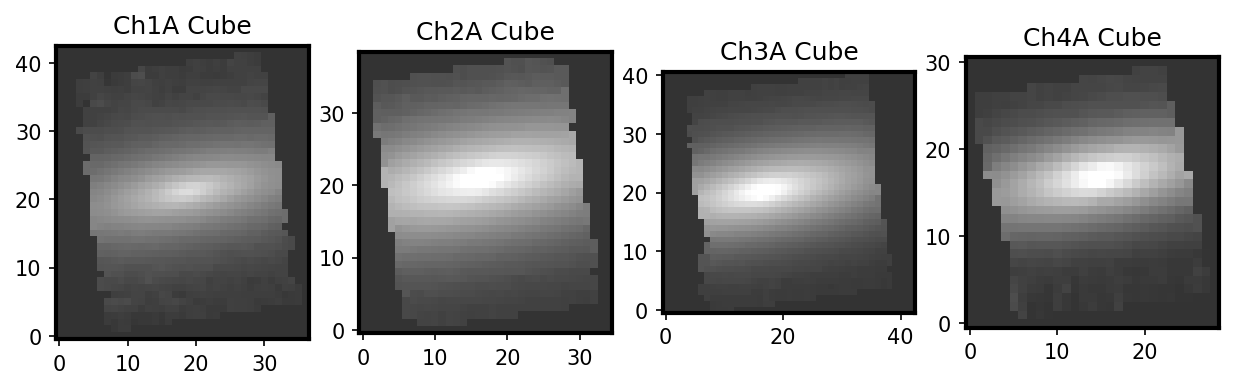

In [25]:
# Read in Ch1A data
hdu1A=fits.open(spec3_dir+'Level3_ch1-short_s3d.fits')
cube1A=hdu1A['SCI'].data
hdr1A=hdu1A['SCI'].header
wave1A=np.arange(hdr1A['NAXIS3'])*hdr1A['CDELT3']+hdr1A['CRVAL3']

# Read in Ch2A data
hdu2A=fits.open(spec3_dir+'Level3_ch2-short_s3d.fits')
cube2A=hdu2A['SCI'].data
hdr2A=hdu2A['SCI'].header
wave2A=np.arange(hdr2A['NAXIS3'])*hdr2A['CDELT3']+hdr2A['CRVAL3']

# Read in Ch3A data
hdu3A=fits.open(spec3_dir+'Level3_ch3-short_s3d.fits')
cube3A=hdu3A['SCI'].data
hdr3A=hdu3A['SCI'].header
wave3A=np.arange(hdr3A['NAXIS3'])*hdr3A['CDELT3']+hdr3A['CRVAL3']

# Read in Ch4A data
hdu4A=fits.open(spec3_dir+'Level3_ch4-short_s3d.fits')
cube4A=hdu4A['SCI'].data
hdr4A=hdu4A['SCI'].header
wave4A=np.arange(hdr4A['NAXIS3'])*hdr4A['CDELT3']+hdr4A['CRVAL3']


# Use a logarithmic stretch to make sure that
# we can see the actual cube footprint well
norm = ImageNormalize(cube1A[0,:,:],stretch=LogStretch(),vmin=-30,vmax=1e4)

rc('axes', linewidth=2)            
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(10,7),dpi=150)

# And plot the data.  Highlight a pixel in the bad column with a red X
ax1.imshow(cube1A[0,:,:], cmap='gray',norm=norm,origin='lower')
ax1.set_title('Ch1A Cube')

ax2.imshow(cube2A[0,:,:], cmap='gray',norm=norm,origin='lower')
ax2.set_title('Ch2A Cube')

ax3.imshow(cube3A[0,:,:], cmap='gray',norm=norm,origin='lower')
ax3.set_title('Ch3A Cube')

ax4.imshow(cube4A[0,:,:], cmap='gray',norm=norm,origin='lower')
ax4.set_title('Ch4A Cube')

<b>Figure 1:</b> Image planes drawn from each of the four simulated wavelength channels

We can also compare the spectra of each of these cubes to the input spectrum.

In [26]:
# Find the mirisim input spectrum
inputsim=ascii.read(mirisim_dir+'ngc5728_mirisim.txt')
inputsim['fnu'] /= 1e6 # Mirisim inputs are in units of uJy; convert to Jy to match pipeline outputs

# Find the 12-band pipeline output 1d spectra
sstring=spec3_dir+'Level3*x1d.fits'
x1dfiles=np.array(sorted(glob.glob(sstring)))

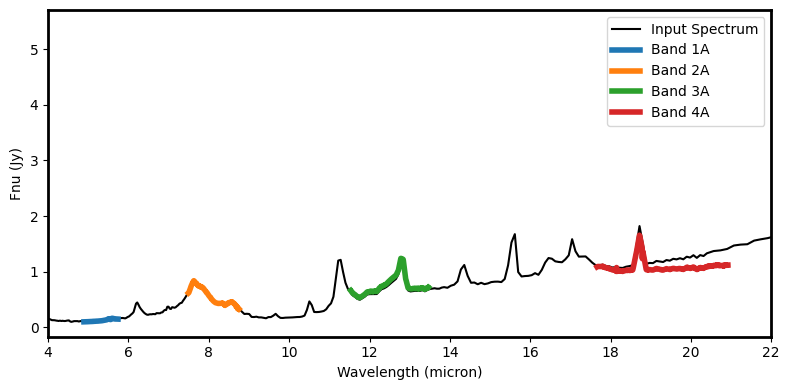

In [27]:
# Plot a spectrum of the source from the Ch1A, Ch1 and ALL cubes
spec1A=fits.open(spec3_dir+'Level3_ch1-short_x1d.fits')
spec2A=fits.open(spec3_dir+'Level3_ch2-short_x1d.fits')
spec3A=fits.open(spec3_dir+'Level3_ch3-short_x1d.fits')
spec4A=fits.open(spec3_dir+'Level3_ch4-short_x1d.fits')

rc('axes', linewidth=2)            
fig, ax = plt.subplots(1,1, figsize=(8,4),dpi=100)

# Rough kludge factor for input spectrum since pipeline 1d spectrum for extended sources does not account for PSF losses
plt.plot(inputsim['wave'],inputsim['fnu']*0.75,label='Input Spectrum',color='black')
plt.plot(wave1A,spec1A['EXTRACT1D'].data['FLUX'],label='Band 1A',linewidth=4,zorder=2)
plt.plot(wave2A,spec2A['EXTRACT1D'].data['FLUX'],label='Band 2A',linewidth=4,zorder=2)
plt.plot(wave3A,spec3A['EXTRACT1D'].data['FLUX'],label='Band 3A',linewidth=4,zorder=2)
plt.plot(wave4A,spec4A['EXTRACT1D'].data['FLUX'],label='Band 4A',linewidth=4,zorder=2)

plt.legend()
plt.xlabel('Wavelength (micron)')
plt.xlim(4,22)
plt.ylabel('Fnu (Jy)')
plt.tight_layout()

spec1A.close()
spec2A.close()
spec3A.close()
spec4A.close()


<b>Figure 2:</b> Spectra of extended sources extracted from data cubes containing Ch1A, Ch2A, Ch3A, and Ch4A.  Note that the input spectrum has been renormalized to account for PSF losses.  Deviations at long wavelengths are due to calibration problems in the simulator.

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://www.stsci.edu/~dlaw/stsci_logo.png" alt="stsci_logo" width="200px"/> 